# Imports

In [1]:
import os
from sys import path
path.append('../')
import cv2

import numpy as np
import pandas as pd

import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib.image import imread
from tensorflow.keras import models, layers
from src.dataset import PneumoniaDetectionChallenge

# Dataset loading for training

In [2]:
DATASET_PATH = '../datasets/rsna-pneumonia-detection-challenge/'

In [3]:
pdc = PneumoniaDetectionChallenge(DATASET_PATH)
x_train, y_train, _ = pdc.load_train_data()

In [4]:
x_train = x_train / 255.0
x_train = x_train.reshape(-1, 256, 256, 1)

In [5]:
x_test, y_test, patients_id = pdc.load_test_data()
x_test = x_test / 255.0
x_test = x_test.reshape(-1, 256, 256, 1)

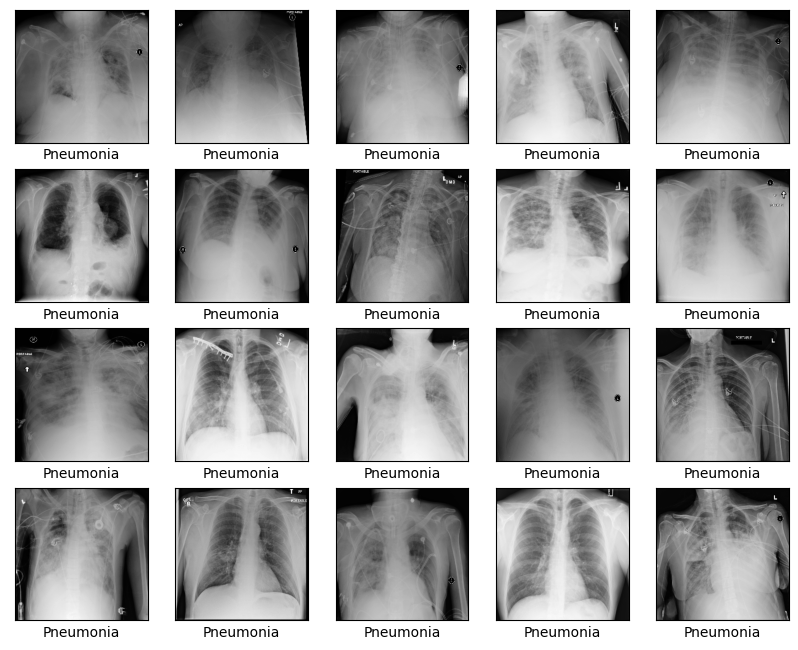

In [6]:
class_names = ['No Pneumonia', 'Pneumonia']

plt.figure(figsize=(10, 10))
for i in range(20):
    plt.subplot(5 ,5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap='gray')
    plt.xlabel(class_names[y_train[i]])
plt.show()
plt.close()

# Mdel definition

In [7]:
model = models.Sequential()

model.add(layers.Conv2D(filters=16, activation='relu', kernel_size=3, padding='same', input_shape=(256, 256, 1)))
model.add(layers.MaxPool2D(pool_size=2, strides=2, padding='valid'))

model.add(layers.Conv2D(filters=32, activation="relu", kernel_size=3, padding="same"))
model.add(layers.MaxPool2D(pool_size=2, strides=2, padding='valid'))

model.add(layers.Conv2D(filters=64, activation="relu", kernel_size=3, padding="same"))
model.add(layers.MaxPool2D(pool_size=2, strides=2, padding='valid'))

model.add(layers.Conv2D(filters=128, activation="relu", kernel_size=3, padding="same"))
model.add(layers.MaxPool2D(pool_size=2, strides=2, padding='valid'))

model.add(layers.Conv2D(filters=128, activation="relu", kernel_size=3, padding="same"))
model.add(layers.MaxPool2D(pool_size=2, strides=2, padding='valid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 16)      160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 128)       7

In [8]:
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 16)      160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 128)       7

In [9]:
model.compile(optimizer='adam',
              loss="binary_crossentropy",
              metrics=['binary_accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')])

# Model training

In [10]:
history = model.fit(x=x_train,
                    y=y_train,
                    validation_data=(x_train, y_train),
                    epochs=30)

Epoch 1/100
310/310 [==============================] - 15s 40ms/step - loss: 0.6483 - binary_accuracy: 0.6025 - precision: 0.5919 - recall: 0.4208 - val_loss: 0.5674 - val_binary_accuracy: 0.7294 - val_precision: 0.7295 - val_recall: 0.6337
Epoch 2/100
310/310 [==============================] - 10s 34ms/step - loss: 0.5702 - binary_accuracy: 0.7217 - precision: 0.7008 - recall: 0.6756 - val_loss: 0.5354 - val_binary_accuracy: 0.7361 - val_precision: 0.7167 - val_recall: 0.6837
Epoch 3/100
310/310 [==============================] - 10s 33ms/step - loss: 0.5518 - binary_accuracy: 0.7354 - precision: 0.7050 - recall: 0.7118 - val_loss: 0.5288 - val_binary_accuracy: 0.7440 - val_precision: 0.7106 - val_recall: 0.7275
Epoch 4/100
310/310 [==============================] - 10s 34ms/step - loss: 0.5391 - binary_accuracy: 0.7357 - precision: 0.7156 - recall: 0.6808 - val_loss: 0.5281 - val_binary_accuracy: 0.7371 - val_precision: 0.7544 - val_recall: 0.6164
Epoch 5/100
310/310 [===============

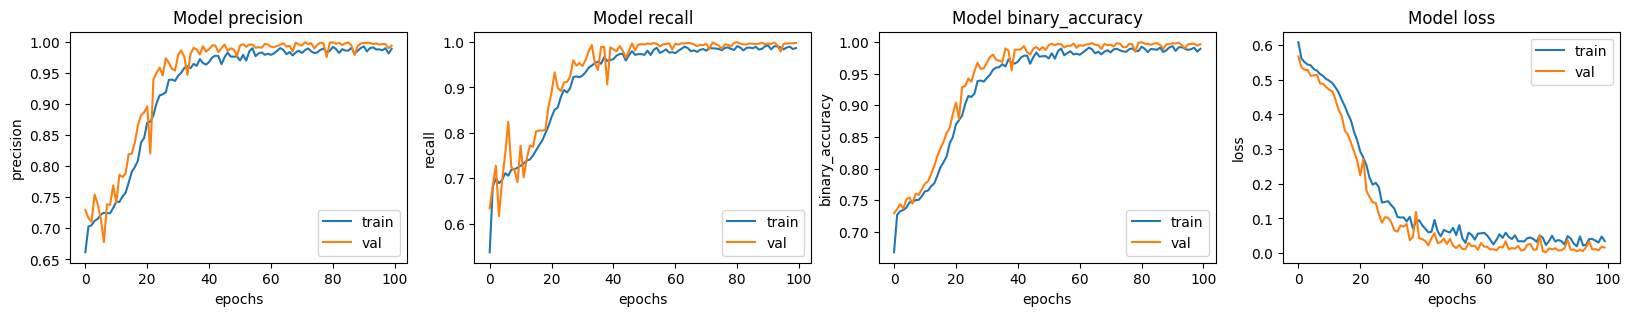

In [11]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'binary_accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

plt.show()

In [12]:
del x_train
del y_train

# Evaluating the model

In [13]:
test_loss, test_accuracy, _, _ = model.evaluate(x_test, y_test)

209/209 [==============================] - 2s 10ms/step - loss: 3.9966 - binary_accuracy: 0.7134 - precision: 0.4289 - recall: 0.6872


In [14]:
predictions = model.predict(x_test)
predictions_rounded = np.round(predictions).astype(int)

In [15]:
test_labels_df = pdc.get_test_labels_df()

for patient_id, prediction in zip(patients_id, predictions_rounded):
    test_labels_df.loc[test_labels_df['patientId'] == patient_id, 'Prediction'] = prediction

test_labels_df.Prediction = test_labels_df.Prediction.astype(int)

In [16]:
hits = test_labels_df[test_labels_df['Target'] == test_labels_df['Prediction']].count()[1]
errors = test_labels_df[test_labels_df['Target'] != test_labels_df['Prediction']].count()[1]

In [17]:
print('General:')
print(' - Total:: ' + str(hits + errors))
print(' - Hits:: ' + str(hits))
print(' - Errors: ' + str(errors))
print(' - Hits ratio: ' + str(hits / (hits + errors)))

General:
 - Total:: 6671
 - Hits:: 4759
 - Errors: 1912
 - Hits ratio: 0.7133862989057113


In [18]:
hits = test_labels_df[(test_labels_df['Target'] == 0) & (test_labels_df['Target'] == test_labels_df['Prediction'])].count()[1]
errors = test_labels_df[(test_labels_df['Target'] == 0) & (test_labels_df['Target'] != test_labels_df['Prediction'])].count()[1]

In [19]:
print('No Pneumonia:')
print(' - Total: ' + str(hits + errors))
print(' - Hits: ' + str(hits))
print(' - Errors: ' + str(errors))
print(' - Hits ratio: ' + str(hits / (hits + errors)))

No Pneumonia:
 - Total: 5114
 - Hits: 3689
 - Errors: 1425
 - Hits ratio: 0.721353148220571


In [20]:
hits = test_labels_df[(test_labels_df['Target'] == 1) & (test_labels_df['Target'] == test_labels_df['Prediction'])].count()[1]
errors = test_labels_df[(test_labels_df['Target'] == 1) & (test_labels_df['Target'] != test_labels_df['Prediction'])].count()[1]

In [21]:
print('Pneumonia:')
print(' - Total: ' + str(hits + errors))
print(' - Hits: ' + str(hits))
print(' - Errors: ' + str(errors))
print(' - Hits ratio: ' + str(hits / (hits + errors)))

Pneumonia:
 - Total: 1557
 - Hits: 1070
 - Errors: 487
 - Hits ratio: 0.6872190109184328
